In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import missingno as msn

In [2]:
df = pd.read_csv('heart.csv')

In [3]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

<AxesSubplot:>

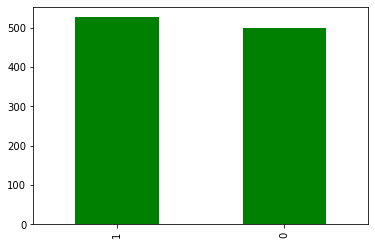

In [4]:
df['target'].value_counts().plot(kind='bar',color='green')

In [5]:
# no neeed to resapmle

In [6]:
y = df['target']
X = df.drop('target',axis=1)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=40)

In [8]:

from sklearn.ensemble import RandomForestClassifier

In [9]:
xgb = RandomForestClassifier()

In [10]:
xgb.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [11]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(100,2000,2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [12]:
grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [13]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True)

In [14]:
from sklearn.model_selection import RandomizedSearchCV
xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=grid, n_jobs=-1,n_iter = 100, cv=cv, scoring='accuracy',error_score=0,return_train_score=True,verbose=2)

In [15]:
xgb_random.fit(X_train,y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
                   error_score=0, estimator=RandomForestClassifier(),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [100, 102, 104, 106, 108,
                                                      110, 112, 114, 116, 118,
                                                      120, 122, 124, 126, 128,
                                                      130, 132, 134, 136, 138,
                                                      140, 142, 144, 146, 148,
                                                      150, 152, 154, 156, 158, ...],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                     

In [16]:
best_model = xgb_random.best_estimator_

In [17]:
best_model

RandomForestClassifier(bootstrap=False, max_depth=940, n_estimators=1213)

In [18]:
xgb_random.best_params_

{'n_estimators': 1213,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 940,
 'bootstrap': False}

In [19]:
xgb_random.best_score_

0.9833137715179967

In [20]:
y_pred = best_model.predict(X_test)

In [21]:
err  =(y_pred- y_test)

<AxesSubplot:>

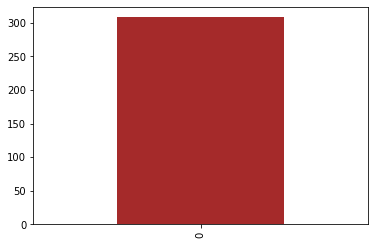

In [22]:
err.value_counts().plot(kind='bar',color='brown')

In [23]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.0
MSE: 0.0
RMSE: 0.0


In [24]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[153   0]
 [  0 155]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       155

    accuracy                           1.00       308
   macro avg       1.00      1.00      1.00       308
weighted avg       1.00      1.00      1.00       308



In [25]:
import pickle
# open a file, where you ant to store the data
file = open('randomforest_heart_disease.pkl', 'wb')
# dump information to that file
pickle.dump(best_model, file)
file.close()